# Tutorial 7 — Hidden Markov Models for Behavioral Analysis

**Author:** [Vito Dichio](https://sites.google.com/view/vito-dichio/home),
Fellow in AI, ENS–PSL, Paris — ✉️ vito.dichio@psl.eu

**Course:** *Machine Learning: Theory and Applications*
Master in Cognitive Sciences, ENS–PSL — Fall 2025/26 (Lecturer: Simona Cocco)

**Format:** Practical Session (TD)
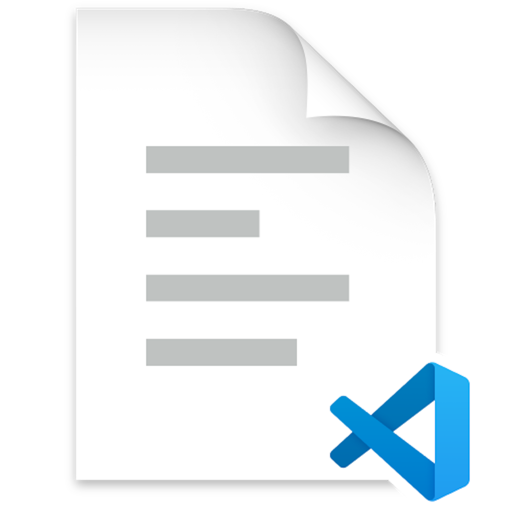

#### Bibliography:

[1] Cocco et al., *From Statistical Physics to Data-Driven Modelling: with Applications to Quantitative Biology*, Oxford University Press (2022) -- Sec. 8.2

[2] Jurafsky & Martin, *Hidden Markov Models*, from *Speech and Language Processing*. Draft of August 24, 2025. Available [here](https://web.stanford.edu/~jurafsky/slp3/A.pdf)

[3] Bishop, *Pattern Recognition and Machine Learning*, Springer (2006) -- Sec. 13.2

[4] Karpenko et al., *From behavior to circuit modeling of light-seeking navigation in zebrafish larvae*, eLife 9, e52882 (2020)

#### 🎯 **Goals**

- Understand the structure and components of Hidden Markov Models (HMMs)
- Apply HMMs to infer hidden behavioral states from observed data
- Analyze zebrafish swimming behavior using HMMs

## Hidden Markov Models

A **Hidden Markov Model (HMM)** is a statistical model used to describe systems that evolve over time with two key characteristics:

1. **Hidden states**: The system is in one of several discrete states at each time step, but we cannot directly observe which state it's in
2. **Observable emissions**: At each time step, the hidden state generates an observable output according to some probability distribution

**Formal definition**: An HMM is defined by
- A set of **hidden states** $\{x_1, x_2, \ldots, x_D\}$
- **Transition probabilities** $\Omega(x \rightarrow x^\prime)$: probability of moving from one state to another
- **Emission probabilities** $\mathcal{E}(y\ |\ x)$: probability of observing output $y$ given hidden state $x$

#### The Markov Property

The model assumes the **Markov property**: the future is independent of the past given the present. Mathematically:
$$P(x_t | x_{t-1}, x_{t-2}, \ldots, x_1) = P(x_t | x_{t-1})$$

This means the probability of being in a state at time $t$ depends only on the state at time $t-1$, not on the entire history.

#### The Three Fundamental Problems of HMMs

Given an HMM with known parameters, there are three fundamental questions we might want to answer. Given a sequence of observations $\mathbf{y} = (y_1, y_2, \ldots, y_T)$:

1. What is the probability that the model generated this sequence? (**Likelihood Problem**)

2. What is the most likely sequence of hidden states $\mathbf{x}^* = (x_1^*, x_2^*, \ldots, x_T^*)$? (**Decoding Problem**)

3. How do we estimate the model parameters $\Omega$ and $\mathcal{E}$? (**Learning Problem**)

In this tutorial, **we focus on the decoding problem**: inferring the most likely sequence of hidden states given observations. We will use the **Viterbi algorithm** to decode zebrafish swimming behavior from observed bout angles.

## Case Study: Zebrafish Swimming Behavior

### Biological Context

**Zebrafish larvae** are a model organism widely used in neuroscience research because their brains are relatively simple (~100,000 neurons) and their behavior is stereotyped and quantifiable. When swimming freely, zebrafish larvae exhibit discrete **swimming bouts** - brief episodes of tail movement that propel the fish through water. Between bouts, the fish glides or remains stationary.

Karpenko+ [4] focused on three main types of swimming bouts in zebrafish larvae: the **forward (F)** the fish swims straight ahead with minimal change in heading direction, the **left turn (L)** where the fish turns to the left, and the **right turn (R)** where the fish turns to the right. These bout types represent **hidden states** -- we cannot directly measure the fish's "intention" to go forward or turn, but we can observe the **consequences** of these decisions.

More precisely, we can observe at each time step the **change in heading angle** (or orientation) $\delta\alpha$ (in radians): small angles indicate forward movement, while larger positive or negative angles indicate right or left turns, respectively. However, there is **noise and variability**: forward bouts sometimes result in small deviations, turn bouts vary in magnitude and there may be measurement errors. This is precisely the situation where an HMM excels: we have noisy observations (variations of the orientation) and want to infer the underlying discrete decisions (F, L, or R).

Note: Karpenko et al. use a clockwise sign convention for heading changes: $\delta\alpha$ is negative for a left turn, positive for a right turn (see Fig. 1b).  Heading angles are recorded immediately before each bout, so `delta_alpha_t = alpha_{t+1} - alpha_{t}` (the last bout of each trajectory has no `delta_alpha`).

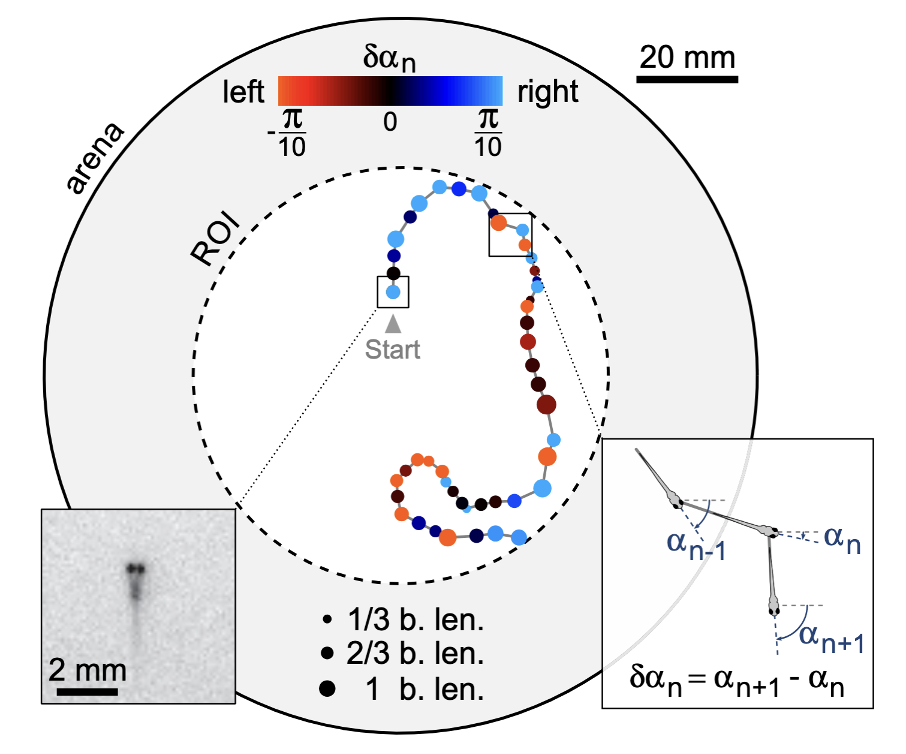

In [2]:
from IPython.display import Image
Image("bibliography/karpenko+2020-1b.png", width=500)

### The HMM Structure for Zebrafish

#### Hidden States

We model zebrafish swimming as an HMM with **three hidden states**:
- **Forward (F)**: Swimming straight ahead
- **Left turn (L)**: Turning left
- **Right turn (R)**: Turning right

These states represent the fish's underlying behavioral decision at each time step, which we cannot directly observe.

#### Transition Probabilities

The transition matrix $\Omega$ describes how the fish switches between behaviors. By symmetry (left and right are equivalent in unbiased swimming), we can parameterize transitions using two probabilities:

- $p_{\text{turn}}$: probability of initiating a turn (vs. continuing forward)
- $p_{\text{flip}}$: probability of reversing turn direction

This gives:
$$\Omega = \begin{pmatrix}
P(F \to F) & P(F \to L) & P(F \to R) \\
P(L \to F) & P(L \to L) & P(L \to R) \\
P(R \to F) & P(R \to L) & P(R \to R)
\end{pmatrix} = \begin{pmatrix}
1 - p_{\text{turn}} & p_{\text{turn}}/2 & p_{\text{turn}}/2 \\
1 - p_{\text{turn}} & p_{\text{turn}}(1-p_{\text{flip}}) & p_{\text{turn}} \ p_{\text{flip}} \\
1 - p_{\text{turn}} & p_{\text{turn}} \ p_{\text{flip}} & p_{\text{turn}}(1-p_{\text{flip}})
\end{pmatrix}$$

#### Emission Probabilities

Each hidden state generates observed angles according to a characteristic distribution:

- **Forward bouts**: Small angles centered at zero
$$\mathcal{E}(\delta\alpha | F) = \mathcal{N}(\delta\alpha; 0, \sigma_F)$$

- **Left turn bouts**: Negative angles only (truncated Gaussian)
$$\mathcal{E}(\delta\alpha | L) = \begin{cases}
2\mathcal{N}(\delta\alpha; 0, \sigma_T) & \text{if } \delta\alpha < 0 \\
0 & \text{if } \delta\alpha \geq 0
\end{cases}$$

- **Right turn bouts**: Positive angles only (truncated Gaussian)
$$\mathcal{E}(\delta\alpha | R) = \begin{cases}
2\mathcal{N}(\delta\alpha; 0, \sigma_T) & \text{if } \delta\alpha > 0 \\
0 & \text{if } \delta\alpha \leq 0
\end{cases}$$

where $\mathcal{N}(x; 0, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-x^2/(2\sigma^2)}$ is the Gaussian (normal) distribution with zero mean and standard deviation $\sigma$. The factor of 2 in the truncated distributions ensures proper normalization.

#### Model Parameters

Based on empirical analysis by Karpenko+ [4], the following parameters were estimated from zebrafish behavioral data:

- $\sigma_F = 0.1$ rad: forward bouts have small angular variability (~5.7°)
- $\sigma_T = 0.6$ rad: turn bouts have larger angular variability (~34.4°)
- $p_{\text{turn}} = 0.41$: fish initiate turns about 41% of the time
- $p_{\text{flip}} = 0.19$: fish reverse turn direction about 19% of the time

**These values will be used throughout the tutorial.** There is no need to re-estimate them (Learning problem). The parameters and the transition matrix are defined below for later use.

In [64]:
import numpy as np

# Parameters from Karpenko et al.
p_turn = 0.41
p_flip = 0.19
sigma_F = 0.1  # rad
sigma_T = 0.6  # rad

# Define transition matrix Ω
omega = np.array([
    # Row 0: transitions FROM Forward
    [1 - p_turn,              p_turn/2,                 p_turn/2],
    # Row 1: transitions FROM Left
    [1 - p_turn,              p_turn*(1-p_flip),    p_turn*p_flip],
    # Row 1: transitions FROM Right
    [1 - p_turn,              p_turn*p_flip,          p_turn*(1-p_flip)]
])

# name mappings for states
state_names = np.array(['F', 'L', 'R'])
# color mappings for states
state_colors = ['#7d7d7d', '#cc3333', '#005a8c']

### Data Structure

The dataset contains recordings from **523 individual zebrafish larvae**, each recorded over a sequence of discrete swimming bouts. All per-bout observations are stored together in a **single pandas DataFrame** where each row corresponds to one bout event.

The DataFrame includes the following columns:

| Column     | Description                                                    |
|------------|----------------------------------------------------------------|
| `fish_idx` | Identifier for the fish (0–522)                                |
| `t_bout`   | Time of bout occurrence (seconds; NaN if unavailable)          |
| `x`, `y`   | Spatial coordinates in millimeters                             |
| `alpha`    | Absolute heading angle (radians)                               |

**Key properties**
- Different fish have **different numbers of bouts** (variable-length time series)
- Data for all fish is **stacked vertically** (not separate tables)
- Heading angle change can be computed per fish as $\delta \alpha_t = \alpha_t - \alpha_{t-1}$
  so each fish has **one fewer** delta-angle value than bouts

To work with a specific fish -- es. `fish_id = 0` -- use `fish_df = full_df[full_df.fish_idx == fish_id]`


In [1]:
import h5py, os
import numpy as np
import pandas as pd

def extract_fish_dfs(mat_path: str, dropna: bool = True, verbose: bool = True) -> pd.DataFrame:
    """
    Efficiently extract per-bout observations for ALL fish in a MATLAB .mat HDF5 file
    and combine into a single long-format DataFrame.

    Columns: ['fish_idx', 't_bout', 'x', 'y', 'alpha']
    """

    def find_dataset(f, target_suffix: str):
        matches = []
        def visitor(name, obj):
            if isinstance(obj, h5py.Dataset) and name.endswith(target_suffix):
                matches.append(name)
        f.visititems(visitor)
        return matches[0] if matches else None

    if verbose:
        print("Opening HDF5 .mat file...")

    with h5py.File(mat_path, 'r') as f:

        angle_path = find_dataset(f, 'Angle')
        time_path  = find_dataset(f, 'TimeBout') or find_dataset(f, 'Time') or find_dataset(f, 'BoutTime')
        x_path     = find_dataset(f, 'Coordinates/x') or find_dataset(f, 'x') or find_dataset(f, 'Coord_x')
        y_path     = find_dataset(f, 'Coordinates/y') or find_dataset(f, 'y') or find_dataset(f, 'Coord_y')

        if angle_path is None:
            raise KeyError("Missing 'Angle' dataset!")

        # Read once
        angle_arr = f[angle_path][()]
        t_arr = f[time_path][()] if time_path else np.full_like(angle_arr, np.nan)
        x_arr = f[x_path][()] if x_path else np.full_like(angle_arr, np.nan)
        y_arr = f[y_path][()] if y_path else np.full_like(angle_arr, np.nan)

        # Normalize shape
        if angle_arr.ndim == 1:
            angle_arr = angle_arr.reshape(-1, 1)

        n_rows, n_fish = angle_arr.shape
        if verbose:
            print(f"Detected dataset: {n_rows} rows × {n_fish} columns")

        mm = 1 / 11.5  # px → mm conversion

        all_rows = []

        for fish_idx in range(n_fish):
            alpha = angle_arr[:, fish_idx]
            t = t_arr[:, fish_idx] if t_arr.ndim == 2 else t_arr
            x = (x_arr[:, fish_idx] if x_arr.ndim == 2 else x_arr) * mm
            y = (y_arr[:, fish_idx] if y_arr.ndim == 2 else y_arr) * mm

            df = pd.DataFrame({
                "fish_idx": fish_idx,
                "t_bout": t,
                "x": x,
                "y": y,
                "alpha": alpha
            })

            if dropna:
                df = df.dropna(how='all', subset=["t_bout", "x", "y", "alpha"])

            all_rows.append(df)

    # Combine everything
    full_df = pd.concat(all_rows, ignore_index=True)

    if verbose:
        print(f"\nFinal dataset size: {len(full_df)} rows.")
        print("Finished extracting all fish.\n")

    return full_df

data_path = os.path.join('data', 'spontaneous_swim.mat')

fish_bouts = extract_fish_dfs(data_path)
print(fish_bouts.head())

Opening HDF5 .mat file...
Detected dataset: 1436 rows × 523 columns

Final dataset size: 16147 rows.
Finished extracting all fish.

   fish_idx    t_bout          x          y     alpha
0         0  0.188173  37.304348  63.478261  2.176144
1         0  0.752694  34.434783  59.565217  2.116500
2         0  1.236568  30.956522  54.260870  2.094446
3         0  1.801088  27.391304  48.869565  2.149090
4         0  2.419372  25.391304  43.913043  1.878000


## 1 - Data exploration and preprocessing

Before implementing the Viterbi algorithm, we need to explore the data and verify that our HMM assumptions are reasonable by comparing observed angle distributions with the theoretical emission model.

### 🎯 Question 1a. Computing Angle Changes from Multiple Trajectories

The data has been loaded into a long-format DataFrame `fish_bouts` with columns `['fish_idx', 't_bout', 'x', 'y', 'alpha']`.

Create a function `collect_all_delta_alpha(fish_bouts)` that:
- Computes angle changes $\delta\alpha_t = \alpha_t - \alpha_{t-1}$ for each fish
- Handles the fact that the first bout of each fish has no previous angle
- Returns all angle changes concatenated into a single 1D array (NaN removed)

**Returns:**
- `all_delta_alpha`: 1D numpy array of all angle changes

Test your function and print the total number of observations collected.

💡 *Hints*:
- Use `groupby('fish_idx')` to process each fish separately [(documentation)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
- The `.diff()` method computes differences within each group [(documentation)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html)
- Remember to remove NaN values (automatically created at group boundaries)

💡 *Remember*: Each trajectory has T bouts but only T-1 angle changes (we cannot compute $\delta\alpha$ for the first bout of each fish).

### 🎯 Question 1b. Visualizing Data vs. Theory

Compare the observed angle distribution with the theoretical emission model. This corresponds to Figure 1D in Karpenko+ [4].

**Task:** Create a plot with:
1. **Histogram** of all observed $\delta\alpha$ values (use `density=True`)
2. **Theoretical mixture** overlaid as a curve

The **marginal distribution** of observed angles (averaging over hidden states) is:
$$P(\delta\alpha) = (1 - p_{\text{turn}}) \cdot \mathcal{N}(\delta\alpha; 0, \sigma_F) + p_{\text{turn}} \cdot \mathcal{N}(\delta\alpha; 0, \sigma_T)$$

According to this formula, with probability 59%, the fish goes forward (narrow peak); with probability 41%, it turns (wide distribution).

**Interpretation questions:**
1. Does the observed distribution match the theoretical mixture reasonably well?
2. Can you distinguish the narrow forward peak from the wider turn distribution?
3. Does the relative height of the peaks match the 59% forward / 41% turn split?

## 2 - Implementing the Viterbi Algorithm

### 🎯 Question 2a. Preliminaries: computing Emission Probabilities

Before implementing Viterbi, we need a function to compute emission probabilities for all three states.

(i) Implement `compute_emission_probs(delta_alpha, sigma_F, sigma_T)` that:
- Takes an array of angle changes, shape `(T,)`
- Returns a matrix of emission probabilities, shape `(T, 3)`
- Row $t$ contains: $[\mathcal{E}(\delta\alpha_t|F), \mathcal{E}(\delta\alpha_t|L), \mathcal{E}(\delta\alpha_t|R)]$

Use the Gaussian probability density functions described in the introduction. For numerical stability, use a small value (e.g., `1e-12`) instead of exactly 0 for impossible emissions (e.g., negative angles for state L).

(ii) **Visualization:** Plot the three emission probability functions over the range $(-\pi, \pi)$ to verify correctness.

(iii) **Test:** Compute the emission probabilities for the angle changes of the first fish (`fish_idx=0`) and print the resulting emission matrix for the first 10 time steps. Verify that the most likely state matches the sign and magnitude of each angle change.

### 🎯 Question 2b. Implementing the Viterbi Algorithm

The Viterbi algorithm finds the most likely sequence of hidden states given observed data using dynamic programming.

#### Algorithm Overview

The algorithm operates in two phases:

1. **Forward pass**: For each time step $t$ and state $x$, compute the maximum log-probability of any path ending in state $x$ at time $t$, and store which previous state achieved this maximum (backpointer).

2. **Backward pass**: Starting from the most likely final state, follow the backpointers to reconstruct the optimal path.

#### Mathematical Formulation

At each time step, we compute:

$$v_t(x_t) = \max_{x_{t-1}} \left[ v_{t-1}(x_{t-1}) + \log P(x_t | x_{t-1}) \right] + \log P(\delta\alpha_t | x_t)$$

where $v_t(x_t)$ is the maximum log-probability of any path ending in state $x_t$ at time $t$.

The logarithms are used to avoid that many small probabilities cause numerical underflow.

💡 **Key insight**: The emission term $\log P(\delta\alpha_t | x_t)$ depends only on the current state $x_t$, not on the previous state $x_{t-1}$. Therefore, when finding $\arg\max_{x_{t-1}}$ (the best previous state), we can **separate** the emission term:

1. Find the best previous state using only: $v_{t-1}(x_{t-1}) + \log P(x_t | x_{t-1})$
2. Then add the emission term: $+ \log P(\delta\alpha_t | x_t)$

This separation simplifies the computation and is reflected in the implementation below.

---

**Task:** Implement `viterbi(E, omega, initial_state=None)` that returns the most likely state sequence.

**Inputs:**
- `E`: emission probability matrix, shape `(T, n_states)` where `E[t, state]` = $P(\delta\alpha_t | \text{state})$
- `omega`: transition matrix, shape `(n_states, n_states)` where `omega[i, j]` = $P(x_{t+1}=j | x_t=i)$
- `initial_state`: starting state (0, 1, 2, ...) or `None` to auto-select based on first emission

**Output:**
- `states`: most likely state sequence, shape `(T,)` with values in {0, 1, ..., n_states-1}

**Algorithm structure:**

**Step 1: Initialize with first observation**

Instead of starting with a fixed initial state, we can incorporate the first observation directly:
```python
T, n_states = E.shape

if initial_state is None:
    # Choose best initial state based on first emission
    v = np.log(E[0, :])
else:
    # Force specific initial state
    v = np.full(n_states, -np.inf)
    v[initial_state] = np.log(E[0, initial_state])

backpointers = np.zeros((T, n_states), dtype=int)
```

**Step 2: Forward pass**

For each time $t = 1, 2, \ldots, T-1$ (starting from $t=1$ since $t=0$ is handled in initialization):
```python
for t in range(1, T):
    v_new = np.zeros(n_states)

    for next_state in range(n_states):
        # Find best previous state (emission term excluded from argmax)
        candidates = v + np.log(omega[:, next_state])
        best_prev = np.argmax(candidates)

        # Add emission term after finding best path
        v_new[next_state] = candidates[best_prev] + np.log(E[t, next_state])
        backpointers[t, next_state] = best_prev

    v = v_new
```

**Key difference from naive approach**: We compute `candidates` using only the transition probabilities, find `argmax`, then add the emission. This is mathematically equivalent but conceptually clearer.

**Step 3: Termination**

The final state is simply:
```python
final_state = np.argmax(v)
```

No need to add emissions again—they're already incorporated in `v`.

**Step 4: Backward pass**
```python
states = np.zeros(T, dtype=int)
states[T-1] = final_state

for t in range(T-2, -1, -1):
    states[t] = backpointers[t+1, states[t+1]]
```

**Analyze the results:**
1. Print state occupancy (percentage of time in each state)
2. Display the first 20 inferred states
3. Compare inferred states with observed angle signs
4. Test with `initial_state=None` vs `initial_state=0` - do results differ significantly?

**Expected behavior:**
- Forward state should dominate (~60-80% of time steps)
- You should observe **persistence**: consecutive time steps in the same state
- Starting with `initial_state=None` may give slightly different results for the first few time steps, but should converge quickly

## 3 - Decoding Zebrafish Behavior with HMMs

Now that we have implemented the Viterbi algorithm, we can apply it to decode swimming behavior from real trajectories and visualize the results.


### 🎯 Question 3a. Visualizing Inferred States Along a Trajectory

Apply the Viterbi algorithm to the first fish and visualize how the inferred hidden states relate to the observed angle changes. Use `plt.scatter` to plot datapoints (x=bout_index, y=$\delta\alpha$) colored by the bout type according to Viterbi, use `state_colors`defined in the introduction.

**Interpretation questions:**
1. Do Forward states correspond to small angle changes near 0?
2. Do Left/Right states align with negative/positive angles?
3. Do you observe persistence (consecutive bouts in the same state)?


### 🎯 Question 3b. Spatial Trajectory Visualization

Visualize the fish's spatial trajectory with states color-coded at each bout location.

**Task:** Create a 2D plot of the fish's path through space: plot the (x, y) coordinates as a trajectory using a dashed line connecting bouts. Overlay scatter points at each bout position, colored by inferred state.

**Interpretation questions:**
1. Can you visually identify turns in the trajectory? Do they correspond to L/R states?
2. Are Forward states associated with straight segments?
3. Does the fish show any directional bias (prefer turning left or right)?